In [26]:
import pandas as pd
train_df = pd.read_csv('S:\\preReBuy\\data_format1\\train_format1.csv')
test_df = pd.read_csv('S:\\preReBuy\\data_format1\\test_format1.csv')
user_info = pd.read_csv('S:\\preReBuy\\data_format1\\user_info_format1.csv')
user_log = pd.read_csv('S:\\preReBuy\\data_format1\\user_log_format1.csv').rename(columns={'seller_id':'merchant_id'})

In [27]:
#填充缺失值
user_info['gender'].fillna(2, inplace=True) #2和null都代表性别不确定
user_info['age_range'].fillna(-1, inplace=True)
user_log['brand_id'].fillna(-1, inplace=True)

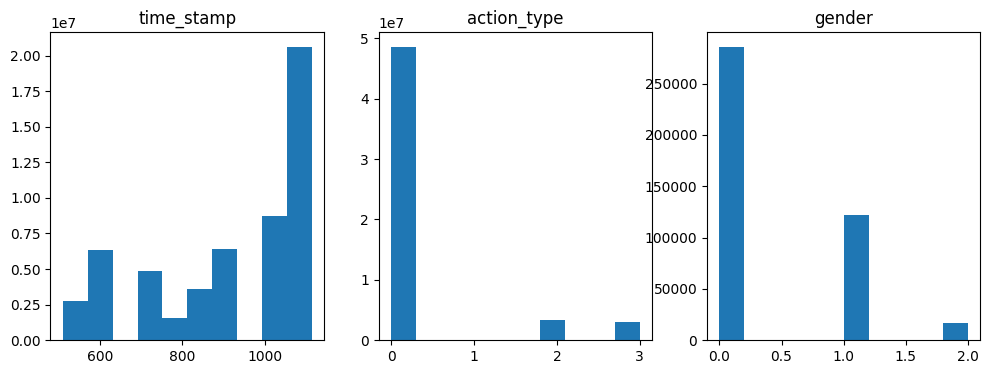

In [17]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(user_log['time_stamp']) #time_tamp 购买时间（格式：mmdd）
plt.title('time_stamp')
plt.subplot(1,3,2)
plt.hist(user_log['action_type'])
plt.title('action_type') #action_type包含{0, 1, 2, 3}，0表示单击，1表示添加到购物车，2表示购买，3表示添加到收藏夹
plt.subplot(1,3,3)
plt.hist(user_info['gender']) #gender用户性别。0表示女性，1表示男性，2和NULL表示未知
plt.title('gender')
plt.show()

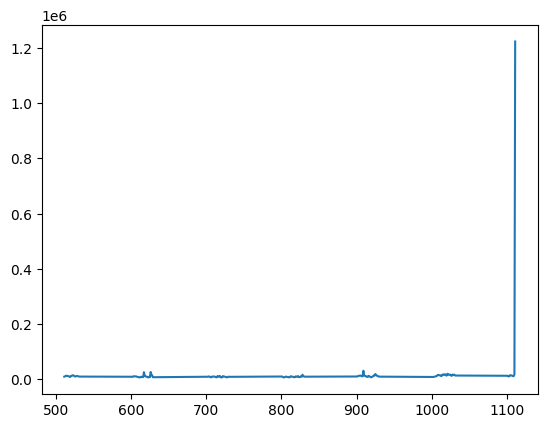

In [18]:
from matplotlib import pyplot as plt
plt.plot(user_log[user_log['action_type']==2].groupby('time_stamp').count()['action_type'])
plt.show()

In [19]:
seller_group = user_log.groupby(["merchant_id","action_type"]).count()[["user_id"]].reset_index().rename(columns={'user_id':'count'})
import gc
del user_log
gc.collect()

14433

In [20]:
#seller_group = user_log.groupby(["seller_id","action_type"]).count()[["user_id"]].reset_index().rename(columns={'user_id':'count'})

#渗透率：
seller_feature = seller_group[seller_group['action_type']==0][['merchant_id','count']].reset_index()[['merchant_id','count']].rename(
    columns={'count':'click_count'})

def _get_action_cnt(num):
    seller_df = seller_group[seller_group['action_type']==num]
    cnt_list = []
    for i in seller_feature['merchant_id']:
        l = list(seller_df['count'][seller_df['merchant_id']==i])
        if l:
            cnt_list.append(l[0])
        else:
            cnt_list.append(0)
    return cnt_list
            
seller_feature['cart_count'] = _get_action_cnt(1)
seller_feature['sell_count'] = _get_action_cnt(2)
seller_feature['star_count'] = _get_action_cnt(3)
seller_feature.head()


,merchant_id,click_count,cart_count,sell_count,star_count
0,1,308236,444,17705,12755
1,2,2030,8,189,144
2,3,2399,4,67,175
3,4,2646,2,294,164
4,5,7483,9,144,556


In [22]:
print(train_df.columns)
print(seller_feature.columns)

Index(['user_id', 'merchant_id', 'label'], dtype='object')
Index(['merchant_id', 'click_count', 'cart_count', 'sell_count', 'star_count'], dtype='object')


In [24]:
train_df = train_df.merge(seller_feature,on="merchant_id",how='left').drop(['merchant_id'],axis=1)
test_df = test_df.merge(seller_feature,on="merchant_id",how='left').drop(['merchant_id'],axis=1)
train_df.to_csv('S:\\preReBuy\\data_format1\\train_v1.csv', index=False)
test_df.to_csv('S:\\preReBuy\\data_format1\\test_v1.csv',index=False)

In [ ]:
train_df = pd.read_csv('./train_v1.csv')
test_df = pd.read_csv('./test_v1.csv')

# 双11相关特征

In [28]:
#都是新用户，就不用看action 2了
for i in (0,1,3):
    user_group = user_log[(user_log['time_stamp']<1111) & (user_log['action_type']==i)].groupby(
        ["user_id","merchant_id"]).count()[["action_type"]].reset_index()
    train_df = train_df.merge(user_group, on=['user_id','merchant_id'],how='left').rename(
        columns={'action_type':'action_type{}'.format(i)})
    test_df = test_df.merge(user_group, on=['user_id','merchant_id'],how='left').rename(
        columns={'action_type':'action_type{}'.format(i)})
for i in (0,1,3):
    user_group = user_log[(user_log['time_stamp']==1111) & (user_log['action_type']==i)].groupby(
        ["user_id","merchant_id"]).count()[["action_type"]].reset_index()
    train_df = train_df.merge(user_group, on=['user_id','merchant_id'],how='left').rename(
        columns={'action_type':'action_type{}_in1111'.format(i)})
    test_df = test_df.merge(user_group, on=['user_id','merchant_id'],how='left').rename(
        columns={'action_type':'action_type{}_in1111'.format(i)})


In [29]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [30]:
for i in (0,1,3):
    train_df['action{}_rate'.format(i)] = train_df.apply(lambda x:x['action_type{}_in1111'.format(i)]/x['action_type{}'.format(i)] if x['action_type{}'.format(i)]>0 else -1, axis=1)
    test_df['action{}_rate'.format(i)] = test_df.apply(lambda x:x['action_type{}_in1111'.format(i)]/x['action_type{}'.format(i)] if x['action_type{}'.format(i)]>0 else -1, axis=1)

In [31]:
train_df.to_csv('S:\\preReBuy\\data_format1\\train_v2.csv')
test_df.to_csv('S:\\preReBuy\\data_format1\\test_v2.csv')

#模型构建和训练&评估# 模型构建和训练&评估

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import lightgbm as lgb

x = train_df.drop(['user_id','merchant_id','label'],axis=1)
y = train_df['label']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2, random_state = 42)

In [34]:
from sklearn import metrics
from matplotlib import pyplot as plt

def plot_roc(y_test, y_score):
    fpr,tpr,threshold = metrics.roc_curve(y_test, y_score)
    roc_auc = metrics.auc(fpr,tpr)
    plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
    plt.plot(fpr, tpr, color='black', lw = 1)
    plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
    plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.show()


# lgb

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] bagging_fraction is set=0.8,

D:\Anaconda\envs\my_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\my_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\my_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


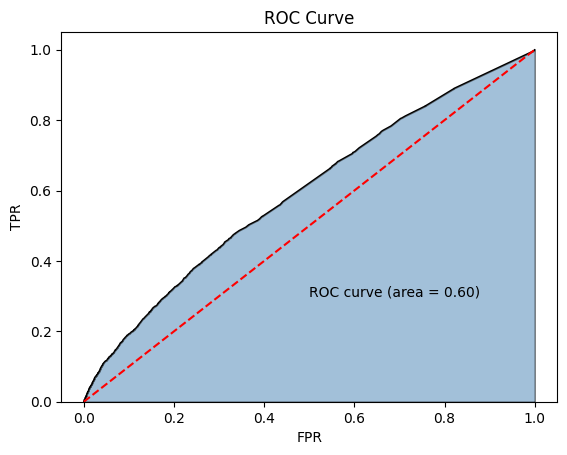

In [42]:
from lightgbm import early_stopping  # 导入 early_stopping
params = {
        'verbose':0,
        'min_data_in_leaf': 4,
        'objective': 'binary',
        'metric': 'auc',
        'num_leaves': 32,
        'n_estimators':2000,
        #'max_bin': 50,
        'max_depth':5,
        "learning_rate": 0.01,
        "colsample_bytree": 0.8,  # 每次迭代中随机选择特征的比例
        "bagging_fraction": 0.8,  # 每次迭代时用的数据比例
        'n_jobs': -1,
        'silent': 1,  # 信息输出设置成1则没有信息输出
        'seed': 42,
        'bagging_freq':3,
        'is_unbalance':True,
        #'scale_pos_weight': wt
    }  #设置出参数

gbm = lgb.LGBMClassifier(**params)
gbm.fit(x_train, y_train, eval_metric='auc',eval_set=[(x_train, y_train), (x_val, y_val)],callbacks=[early_stopping(stopping_rounds=30)])
gbm_pred = gbm.predict(x_val)
gbm_proba = gbm.predict_proba(x_val)
print('模型的评估报告：\n',classification_report(y_val, gbm_pred))
plot_roc(y_val, gbm_proba[:,1])

模型的评估报告：
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     49026
           1       0.00      0.00      0.00      3147

    accuracy                           0.94     52173
   macro avg       0.47      0.50      0.48     52173
weighted avg       0.88      0.94      0.91     52173



D:\Anaconda\envs\my_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\my_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\my_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


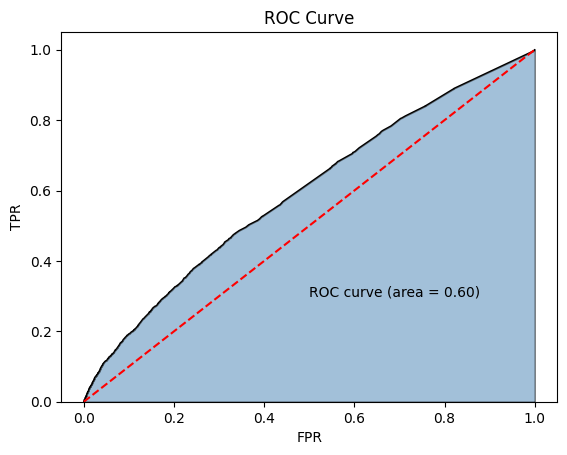

In [43]:
print('模型的评估报告：\n',classification_report(y_val, gbm_pred))
plot_roc(y_val, gbm_proba[:,1])

#lgb结果 

In [51]:
prob = gbm.predict_proba(test_df.drop(['user_id','merchant_id','prob'],axis=1))
test_df['prob'] = pd.Series(prob[:,1])
test_df[['user_id', 'merchant_id', 'prob']].to_csv('S:\\preReBuy\\data_format1\\prediction.csv', index=False)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


KeyError: "['user_id, merchant_id'] not in index"

In [52]:
pred = pd.read_csv('S:\\preReBuy\\data_format1\\prediction.csv')
pred.head()

,user_id,merchant_id,prob
0,163968,4605,0.159213
1,360576,1581,0.163417
2,98688,1964,0.163417
3,98688,3645,0.178307
4,295296,3361,0.222196
